<a href="https://colab.research.google.com/github/abhi1628/DS-ML-Projects/blob/main/Movie_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv('/content/IMDb Movies India.csv',encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [55]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali



 Cleaned Numeric Data (head):
     Year  Duration  Rating  Votes
1  2019.0     109.0     7.0    8.0
2  2021.0      90.0     NaN    NaN
3  2019.0     110.0     4.4   35.0
4  2010.0     105.0     NaN    NaN
5  1997.0     147.0     4.7  827.0

 Correlation Matrix:
              Year  Duration    Rating     Votes
Year      1.000000 -0.374097 -0.166673  0.129016
Duration -0.374097  1.000000 -0.031093  0.099660
Rating   -0.166673 -0.031093  1.000000  0.126635
Votes     0.129016  0.099660  0.126635  1.000000


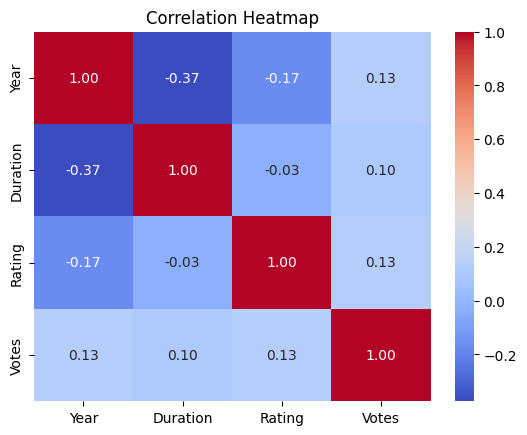

In [56]:
# Clean 'Year' column → extract digits from parentheses like '(2021)'
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Clean 'Duration' column → convert '109 min' to 109
df['Duration'] = df['Duration'].astype(str).str.extract(r'(\d+)')
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# Clean 'Votes' column → remove commas and convert to int
df['Votes'] = df['Votes'].astype(str).str.replace(',', '', regex=True)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

# Keep only numeric columns for correlation
numeric_df = df[['Year', 'Duration', 'Rating', 'Votes']]

# Drop rows with all NaNs in numeric columns (optional)
numeric_df = numeric_df.dropna(how='all')

# Show cleaned data preview
print("\n Cleaned Numeric Data (head):")
print(numeric_df.head())

# Correlation matrix
print("\n Correlation Matrix:")
print(numeric_df.corr())

# Optional: visualize with heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [57]:
# Ensure that we're modifying the original DataFrame
df = df.copy()  # This ensures that you're working with a copy of the original dataframe

# Create a Duration Category Feature
def categorize_duration(duration):
    if duration <= 90:
        return 'Short'
    elif duration <= 120:
        return 'Medium'
    else:
        return 'Long'

# Apply the category transformation safely
df['Duration_Category'] = df['Duration'].apply(categorize_duration)

# Now drop the 'Duration' column after categorization
df = df.drop(columns=['Duration'])

# Proceed with checking the data after modification
print("\nHead of cleaned data:")
print(df.head())


Head of cleaned data:
                                 Name    Year            Genre  Rating  Votes  \
0                                         NaN            Drama     NaN    NaN   
1  #Gadhvi (He thought he was Gandhi)  2019.0            Drama     7.0    8.0   
2                         #Homecoming  2021.0   Drama, Musical     NaN    NaN   
3                             #Yaaram  2019.0  Comedy, Romance     4.4   35.0   
4                   ...And Once Again  2010.0            Drama     NaN    NaN   

             Director       Actor 1             Actor 2          Actor 3  \
0       J.S. Randhawa      Manmauji              Birbal  Rajendra Bhatia   
1       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande    Arvind Jangid   
2  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur       Roy Angana   
3          Ovais Khan       Prateik          Ishita Raj  Siddhant Kapoor   
4        Amol Palekar  Rajat Kapoor  Rituparna Sengupta      Antara Mali   

  Duration_Category  
0          

In [58]:
# Step 1: Select features and target
features = ['Year', 'Duration_Category', 'Votes']
target = 'Rating'

X = df[features]
y = df[target]

# ----> One-hot encoding for 'Duration_Category' <----
X = pd.get_dummies(X, columns=['Duration_Category'], drop_first=True)

# Option 1: Impute with the mean (for numerical features)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
X = imputer.fit_transform(X)

# *** Handle missing values in the target variable (y) ***
y = y.dropna()  # Remove rows with NaN values in 'Rating'

# *** Update X to match the rows in y after dropping NaNs ***
X = X[y.index]  # Select rows in X corresponding to the remaining rows in y

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Step 4: Predict
y_pred = lr.predict(X_test)

# Step 5: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Performance:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


Linear Regression Performance:
MAE: 1.031
RMSE: 1.294
R² Score: 0.099


In [59]:
# Step 1: Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 2: Predict
y_pred_rf = rf.predict(X_test)

# Step 3: Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Performance:")
print(f"MAE: {mae_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R² Score: {r2_rf:.3f}")

Random Forest Performance:
MAE: 0.978
RMSE: 1.291
R² Score: 0.104


In [60]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)
print("Gradient Boosting Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gbm):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbm)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred_gbm):.3f}")

Gradient Boosting Performance:
MAE: 0.880
RMSE: 1.165
R² Score: 0.270


In [61]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')  # You can try other kernels like 'linear', 'poly', etc.
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
print("SVM Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_svr):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_svr)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred_svr):.3f}")

SVM Performance:
MAE: 1.073
RMSE: 1.349
R² Score: 0.022


In [62]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.3f}")

XGBoost Performance:
MAE: 0.941
RMSE: 1.264
R² Score: 0.141


In [63]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lgbm):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgbm)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred_lgbm):.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 6335, number of used features: 4
[LightGBM] [Info] Start training from score 5.831018
LightGBM Performance:
MAE: 0.881
RMSE: 1.175
R² Score: 0.257


In [64]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_knn):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn)):.3f}")
print(f"R² Score: {r2_score(y_test, y_pred_knn):.3f}")

KNN Performance:
MAE: 0.995
RMSE: 1.292
R² Score: 0.102


In [67]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available processors
                           verbose=2,  # Print progress
                           scoring='neg_mean_squared_error')  # We use RMSE (lower is better)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters found from the GridSearchCV
print(f"\nBest parameters found: {grid_search.best_params_}")

# Step 5: Predict using the best model from GridSearchCV
best_rf = grid_search.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

# Step 6: Evaluate the performance of the tuned model
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("\nRandom Forest Performance (With Tuning):")
print(f"MAE: {mae_rf_tuned:.3f}")
print(f"RMSE: {rmse_rf_tuned:.3f}")
print(f"R² Score: {r2_rf_tuned:.3f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Random Forest Performance (With Tuning):
MAE: 0.888
RMSE: 1.175
R² Score: 0.257
